<div style="direction:rtl;text-align:center"><img src="https://dl.mohammadkh.ir/logo.png" alt="Mohammadkh.ir" style="width: 250px;"/></div>
<h1><div style="direction:rtl;text-align:center">Neural Network</div></h1>

In [1]:
import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
import os
import glob
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import concatenate, Input, Conv2D, MaxPooling2D, Activation, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model
from sklearn.metrics import r2_score, mean_absolute_error

### Load data and preprocess

In [2]:
data = pd.read_csv('../__data/Houses Dataset/HousesInfo.txt', header=None, sep=' ', 
                   names=['bedrooms', 'bathrooms', 'area', 'zipcode', 'price'])

data[:2]

,bedrooms,bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200


['../__data/Houses Dataset\\1_bathroom.jpg', '../__data/Houses Dataset\\1_bedroom.jpg', '../__data/Houses Dataset\\1_frontal.jpg', '../__data/Houses Dataset\\1_kitchen.jpg']
(4, 32, 32, 3)


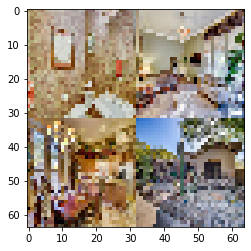

(535, 64, 64, 3)

In [3]:
# ex:
print(sorted(list(glob.glob(os.path.sep.join(['../__data/Houses Dataset', "%i_*"%(1)])))))
basepath = os.path.sep.join(['../__data/Houses Dataset', "{}_*".format(1)])
imgPaths = sorted(list(glob.glob(basepath)))
inputImages = []
for imgPath in imgPaths:
    image = cv2.resize(cv2.imread(imgPath), (32, 32))
    inputImages.append(image)
print(np.shape(inputImages))
outputImage = np.zeros((64, 64, 3), dtype='uint8')
outputImage[0:32, 0:32] = inputImages[0]
outputImage[0:32, 32:64] = inputImages[1]
outputImage[32:64, 32:64] = inputImages[2]
outputImage[32:64, 0:32] = inputImages[3]
outputImage = cv2.cvtColor(outputImage, cv2.COLOR_BGR2RGB)
plt.imshow(outputImage)
plt.show()
# ex

images = []
for i in data.index.values:
    basepath = os.path.sep.join(['../__data/Houses Dataset', "{}_*".format(i + 1)])
    imgPaths = sorted(list(glob.glob(basepath)))
    inputImages = []
    for imgPath in imgPaths:
        image = cv2.resize(cv2.imread(imgPath), (32, 32))
        inputImages.append(image)
    outputImage = np.zeros((64, 64, 3), dtype='uint8')
    outputImage[0:32, 0:32] = inputImages[0]
    outputImage[0:32, 32:64] = inputImages[1]
    outputImage[32:64, 32:64] = inputImages[2]
    outputImage[32:64, 0:32] = inputImages[3]
    images.append(outputImage)
images = np.array(images)
images.shape

In [4]:
X_train, X_test, IX_train, IX_test = train_test_split(data, images, random_state=523)

# StandardScaler
## label
maxPrice = X_train['price'].max()
y_train = X_train['price'] / maxPrice
y_test = X_test['price'] / maxPrice
## all futer - zipcod
ss = StandardScaler()
XT = ss.fit_transform(X_train[['bedrooms', 'bathrooms', 'area']])
Xt = ss.transform(X_test[['bedrooms', 'bathrooms', 'area']])
## zip cod 
lb = LabelBinarizer()
lb.fit(data['zipcode'])
XTz = lb.transform(X_train['zipcode'])
Xtz = lb.transform(X_test['zipcode'])
## futer + zip cod
XT = np.hstack([XT, XTz])
Xt = np.hstack([Xt, Xtz])

### create model and fit

In [5]:
input1 = Input(shape=(64, 64, 3))
conv1 = Conv2D(64, (3, 3), padding='same', activation='relu')(input1)
batchnorm1 = BatchNormalization(axis=-1)(conv1)
maxpool1 = MaxPooling2D(pool_size=(2, 2))(batchnorm1)
conv2 = Conv2D(128, (3, 3), padding='same', activation='relu')(maxpool1)
batchnorm2 = BatchNormalization(axis=-1)(conv2)
maxpool2 = MaxPooling2D(pool_size=(2, 2))(batchnorm2)
conv3 = Conv2D(256, (3, 3), padding='same', activation='relu')(maxpool2)
batchnorm3 = BatchNormalization(axis=-1)(conv3)
maxpool3 = MaxPooling2D(pool_size=(2, 2))(batchnorm3)
flatten1 = Flatten()(maxpool3)
dense1 = Dense(64, activation='relu')(flatten1)
batchnorm4 = BatchNormalization(axis=-1)(dense1)
dropout1 = Dropout(0.5)(batchnorm4)
dense2 = Dense(32, activation='relu')(dropout1)

m1 = Model(input1, dense2)

m1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 128)      512   

In [6]:
m2 = Sequential()
m2.add(Dense(512, activation='relu', input_dim=52))
m2.add(Dropout(0.3))
m2.add(Dense(256, activation='relu'))
m2.add(Dropout(0.3))
m2.add(Dense(128, activation='relu'))
m2.add(Dropout(0.3))
m2.add(Dense(64, activation='relu'))
m2.add(Dropout(0.3))
m2.add(Dense(32, activation='relu'))
m2.add(Dropout(0.3))

m2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               27136     
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8

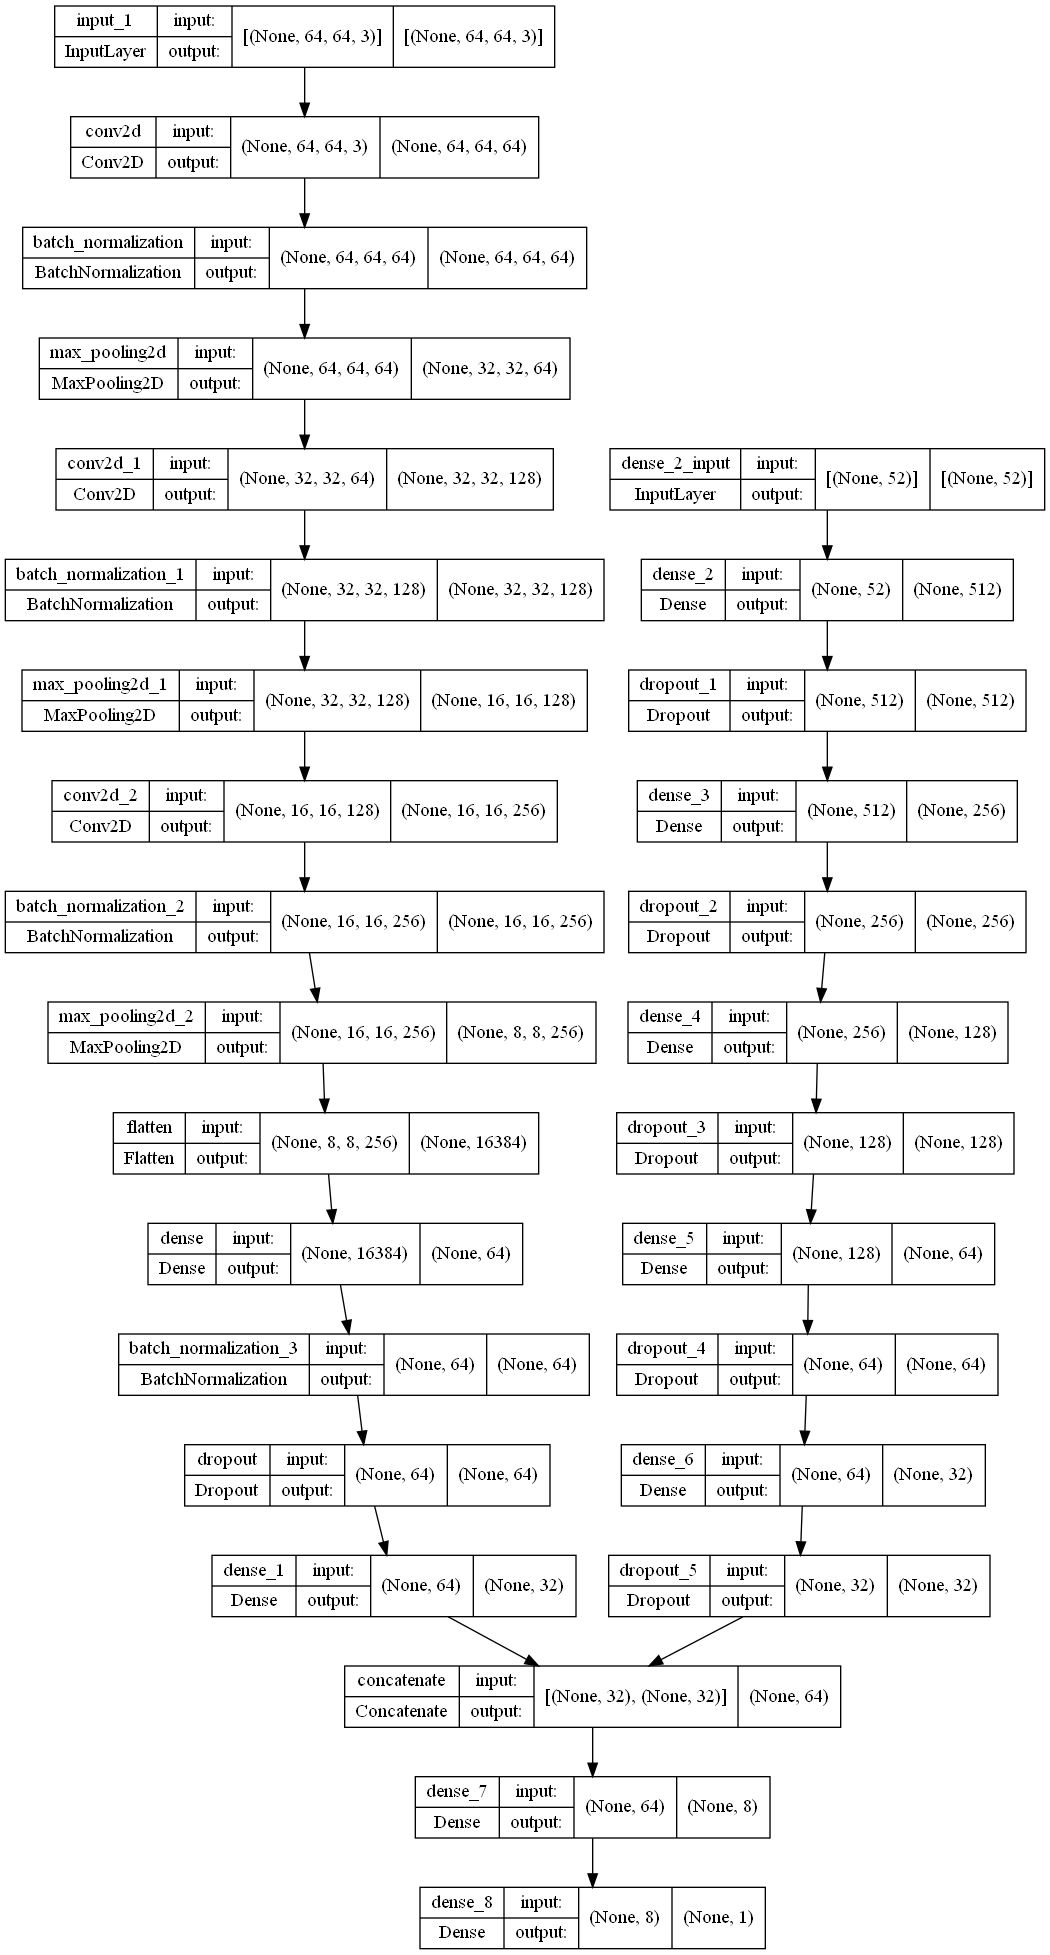

In [7]:
combinedModel = concatenate([m2.output, m1.output])

densef1 = Dense(8, activation='relu')(combinedModel)
densef2 = Dense(1, activation='linear')(densef1)
model = Model(inputs=[m2.input, m1.input], outputs=densef2)

# model.summary()

plot_model(model, show_shapes=True)

In [8]:
model.compile(loss='mean_absolute_error', optimizer='adam')

In [16]:
model.fit([XT, IX_train], y_train, validation_data=([Xt, IX_test], y_test), epochs=5, batch_size=256)

Epoch 1/5
2/2 [==============================] - 2s 1s/step - loss: 0.0695 - val_loss: 0.0701
Epoch 2/5
2/2 [==============================] - 2s 1s/step - loss: 0.0642 - val_loss: 0.0709
Epoch 3/5
2/2 [==============================] - 2s 1s/step - loss: 0.0607 - val_loss: 0.0711
Epoch 4/5
2/2 [==============================] - 2s 1s/step - loss: 0.0650 - val_loss: 0.0696
Epoch 5/5
2/2 [==============================] - 2s 1s/step - loss: 0.0567 - val_loss: 0.0682


### predict

In [17]:
predicts = model.predict([Xt, IX_test]) * maxPrice

In [18]:
diff = abs(predicts.flatten() - (y_test * maxPrice))
mean_diff = np.mean(diff)
std_diff = np.std(diff)

mean = (y_test * maxPrice).mean()
std = (y_test * maxPrice).std()

print('predict : mean = %.2f , std = %.2f\ndata : mean = %.2f , std = %.2f'%(mean_diff, std_diff, mean, std))

predict : mean = 272866.03 , std = 539014.19
data : mean = 621685.57 , std = 648430.76


In [19]:
r2_score(y_pred=predicts.flatten(), y_true=(y_test * maxPrice))

0.1253999967811611

<div class="alert alert-block alert-info">
<div style="direction:rtl;text-align:left"><strong>Neural Network</strong><br>MohammadReza <strong>Khajedaloi</strong><br><br>
</div>
<div style="direction:rtl;text-align:right">
<a href="http://mohammadkh.ir/">WebSite</a> - <a href="https://github.com/khajedaloi/">GitHub</a> - <a href="https://www.linkedin.com/in/mohammad-kh/">Linkedin</a>
</div>
</div>